In [1]:
# Imports
from network import HopfieldNetwork
from scipy.io import wavfile
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

%matplotlib inline

# Testing simple single pitch storage and denoising

We will start by trying to store an a440 pitch into the Hopfield network. We will then add noise to the pitch and see if the Hopfield network can recover the initial pitch.

### Extracting audio data

In [2]:
# Globals
SCALE_FACTOR = 64
BIT_PRECISION = 8

/var/folders/n5/xwtct4t51_zc76hz3mm3bcmc0000gn/T/ipykernel_27380/2829795837.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(file_path)


12.801161103047896


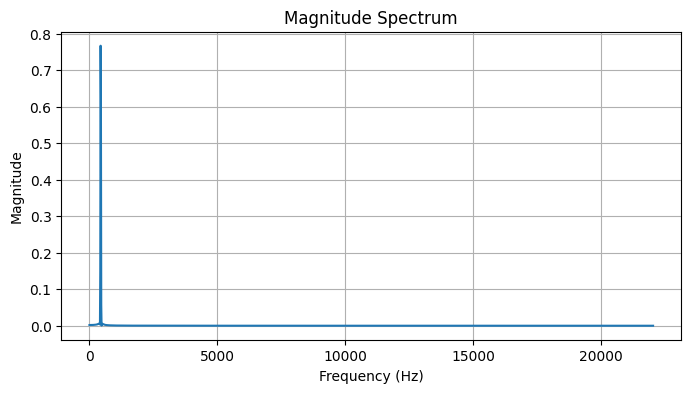

In [3]:
# reach out to Tom Griffis.
file_path = './audio/Sine_wave_440.wav'

# Read the wav file
sample_rate, data = wavfile.read(file_path)

sample = data[:len(data)//SCALE_FACTOR]

# Apply windowing to the sample (e.g., Hamming window)
windowed_sample = sample * signal.hamming(len(sample))

# Take the fourier transform of the wav file, reduce the size for memory efficiency TODO: figure out optimal n
fft_result = np.fft.fft(windowed_sample)

# Frequencies corresponding to the FFT result
frequencies = np.fft.fftfreq(len(fft_result), 1/sample_rate)
print(np.abs(frequencies[0] - frequencies[1]))

# Get the magnitudes and normalize
magnitudes = np.abs(fft_result)[:len(frequencies)//2]
norm_mags = normalize(magnitudes.reshape(-1, 1), axis=0)
norm_mags.reshape(magnitudes.shape)

# Plot the magnitude spectrum
plt.figure(figsize=(8, 4))
plt.plot(frequencies[:len(frequencies)//2], norm_mags[:len(frequencies)//2])
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.savefig("original_440.jpg")
plt.show()

In [4]:
# Just a test
from audio_processing import mags_to_wav

mags_to_wav("original_test.wav", magnitudes, 3, sample_rate)

Above we can see a plot of the fourier transform, with a clear spike at 440Hz

### Converting audio data to binary format for Hopfield Network

Hopfield Networks require binary data, so we need to find a way to represent the audio data without losing too much information.

We will store the data in an array, where each row represents one of the frequencies in the fourier transform, and the value of the row is an array of length 64, representing the float64 binary number for the corresponding magnitude.

We define the below function to binarize audio data:

(1722, 8)
<class 'numpy.int8'>


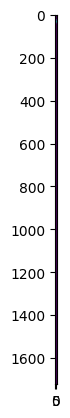

In [5]:
# Helper function linearly maps number from [0,1] to a 6-bit number in [0,63]
def float_to_bin_array(num):
    # check data is normalized
    if num < 0 or num > 1:
        raise ValueError("Input value must be in the range [0,1]")
    binary_array = np.binary_repr(int(num * (2 ** BIT_PRECISION - 1)), width=BIT_PRECISION)
    binary_array = np.array(list(map(np.int8, binary_array)))
    binary_array[binary_array == 0] = -1
    return binary_array

def binarize_audio(magnitude_data):
    bin_data = []
    for d in magnitude_data:
        bin_arr = float_to_bin_array(d)
        bin_data.append(bin_arr)
    bin_data = np.array(bin_data)
    return bin_data





bin_data = binarize_audio(norm_mags)
print(np.shape(bin_data))
print(type(bin_data[0][0]))
plt.imshow(bin_data)

### Training the Hopfield network

We first need to flatten the data for training in the Hopfield network.

In [15]:
# Function to preprocess binary "image" of data
def preprocessing(img, w, h):
    # Flatten image
    flatten = np.reshape(img, (w*h))
    return flatten

# Initialize the Hopfield network
model = HopfieldNetwork()

# Only one data point to train, but input needs to be a list
train_data = [preprocessing(bin_data, w=len(bin_data), h=BIT_PRECISION)]

print(train_data[0].shape)
print(type(train_data[0][0]))

(13776,)
<class 'numpy.int8'>


In [16]:
# Train the weights in the network
model.train_weights(train_data)

Start to train weights...
13776
aqui
Weights initialized
(13776, 13776)


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Hebb rule step done


### Adding simple noise to the original audio

We add noise by setting a corruption level in [0, 1]. We then pick some of the frequencies each with probability of the corruption level, and then set their magnitude to be between 0 and the maximum magnitude scaled by the corruption level.

We also write a function to "unbinarize" the data for plotting.

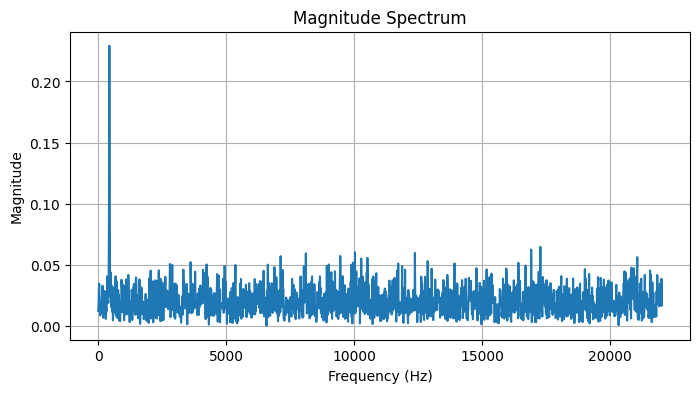

In [17]:
def get_corrupted_input(data, corruption_level):
    # Generate random noise
    noise = np.random.normal(scale=corruption_level, size=data.shape)
    
    # Introduce corruption
    corrupted_data = data.astype(np.float32) + noise
    
    # Clip values to stay within valid range
    corrupted_data = np.clip(corrupted_data, -32767, 32767)
    
    # Convert back to int16
    corrupted_data = corrupted_data.astype(np.int16)

    return corrupted_data

corrupted_data = get_corrupted_input(data, corruption_level=50000)
corrupted_fft = np.fft.fft(corrupted_data, len(corrupted_data)//SCALE_FACTOR)
corrupted_fft_mags = np.abs(corrupted_fft[:len(corrupted_fft)//2])
norm_corrupted = normalize(corrupted_fft_mags.reshape(-1, 1), axis=0)

# Function to retrieve original mag data from corrupted data
def unbinarize_data(binarized_data):
    original_mags = []
    data = np.array(binarized_data, dtype=np.int8)
    data[data == -1] = 0
    data = np.array(data, dtype=np.uint8)
    for d in data:
        # Convert the binary array to a packed binary representation
        d = np.insert(d, 0, np.array([0] * (8 -BIT_PRECISION), dtype=np.int8))
        packed_binary = np.packbits(d)
        packed_binary = np.array(packed_binary, dtype=np.float64)
        packed_binary /= 2 ** BIT_PRECISION - 1
        # Unpack the binary representation into a float64 value
        original_mags.append(packed_binary)
    return np.array(original_mags)

# Plot the corrupted magnitude spectrum
plt.figure(figsize=(8, 4))
plt.plot(frequencies[:len(frequencies)//2], norm_corrupted)
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.savefig("440_noisy.jpg")
plt.show()

In [18]:
from audio_processing import mags_to_wav

mags_to_wav("corrupted.wav", corrupted_fft_mags, 3, sample_rate)

### Try to recover original signal

Finally, we use the trained network to try and recover the original signal, absent any noise.

Start to predict...


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Show prediction results...


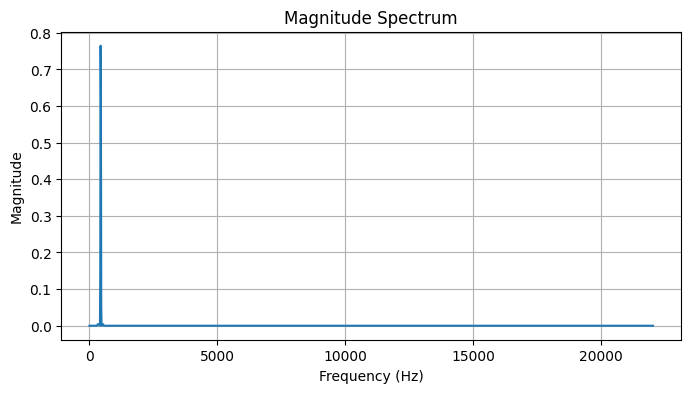

In [19]:
# Binarize first
bin_corrupted = binarize_audio(norm_corrupted)

test_data = [preprocessing(bin_corrupted, w=len(bin_corrupted), h=BIT_PRECISION)]

predicted = model.predict(test_data, num_iter=50, threshold=0, asyn=False)
predicted = np.array(predicted)
predicted = predicted.reshape(predicted.size // BIT_PRECISION, BIT_PRECISION)

unbinarized_prediction = unbinarize_data(predicted)
#norm_prediction = normalize(unbinarized_prediction, axis=0)

print("Show prediction results...")
plt.figure(figsize=(8, 4))
plt.plot(frequencies[:len(frequencies)//2], unbinarized_prediction)
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.savefig("cleaned_440.jpg")
plt.show()

In [12]:
print(unbinarized_prediction.shape)
mags_to_wav("440_out.wav", unbinarized_prediction.squeeze(), 3, sample_rate)

(1722, 1)


# Storing multiple (3) pitches and evaluating performance

Now to test how well the network can differentiate between three different noisy pitches. First we'll make a plotting function to save time:

In [13]:
def plot(frequencies, train_magnitudes, test_data, prediction, figsize=(10, 6)):
    data = [d.reshape(d.size // BIT_PRECISION, BIT_PRECISION) for d in train_magnitudes]
    test = [d.reshape(d.size // BIT_PRECISION, BIT_PRECISION) for d in test_data]
    predicted = [d.reshape(d.size // BIT_PRECISION, BIT_PRECISION) for d in prediction]

    data = [unbinarize_data(d) for d in data]
    test = [unbinarize_data(d) for d in test]
    predicted = [unbinarize_data(d) for d in predicted]

    fig_1, axarr_1 = plt.subplots(len(data), 3, figsize=figsize)
    fig_2, axarr_2 = plt.subplots(len(data), 3, figsize=figsize)
    for i in range(len(data)):
        if i==0:
            axarr_1[i, 0].set_title('Train data')
            axarr_1[i, 1].set_title("Input data")
            axarr_1[i, 2].set_title('Output data')
            axarr_2[i, 0].set_title('Train data')
            axarr_2[i, 1].set_title("Input data")
            axarr_2[i, 2].set_title('Output data')

        axarr_1[i, 0].plot(frequencies, data[i])
        axarr_1[i, 1].plot(frequencies, test[i])
        axarr_1[i, 2].plot(frequencies, predicted[i])
        axarr_2[i, 0].imshow(train_magnitudes[i].reshape(train_magnitudes[i].size // BIT_PRECISION, BIT_PRECISION), aspect='auto', interpolation='none')
        axarr_2[i, 1].imshow(test_data[i].reshape(test_data[i].size // BIT_PRECISION, BIT_PRECISION), aspect='auto', interpolation='none')
        axarr_2[i, 2].imshow(prediction[i].reshape(prediction[i].size // BIT_PRECISION, BIT_PRECISION), aspect='auto', interpolation='none')

    plt.tight_layout()
    plt.savefig("result.png")
    plt.show()

/var/folders/n5/xwtct4t51_zc76hz3mm3bcmc0000gn/T/ipykernel_59789/1254223935.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data_250 = wavfile.read(two50)
/var/folders/n5/xwtct4t51_zc76hz3mm3bcmc0000gn/T/ipykernel_59789/1254223935.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data_440 = wavfile.read(four40)


(3, 13776)
Start to train weights...
13776
aqui
Weights initialized
(13776, 13776)


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Hebb rule step done
Finished training
(13776,)
Start to predict...


100%|██████████| 3/3 [00:00<00:00,  5.98it/s]


Show prediction results...


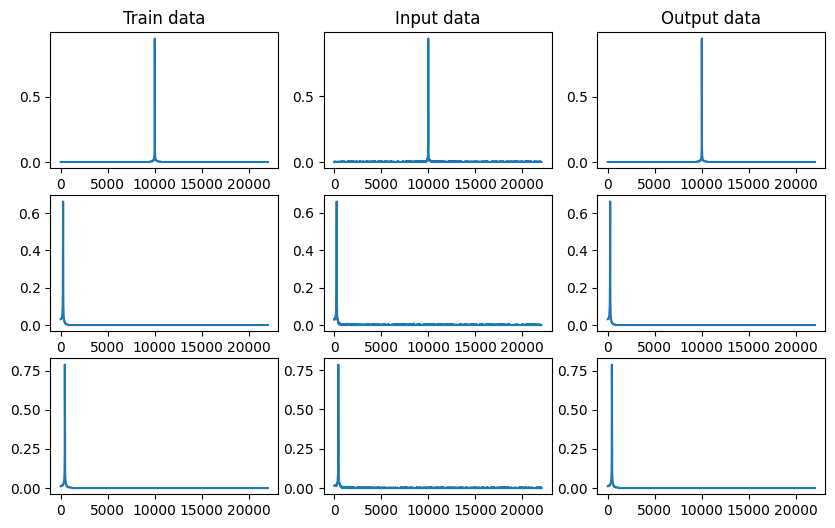

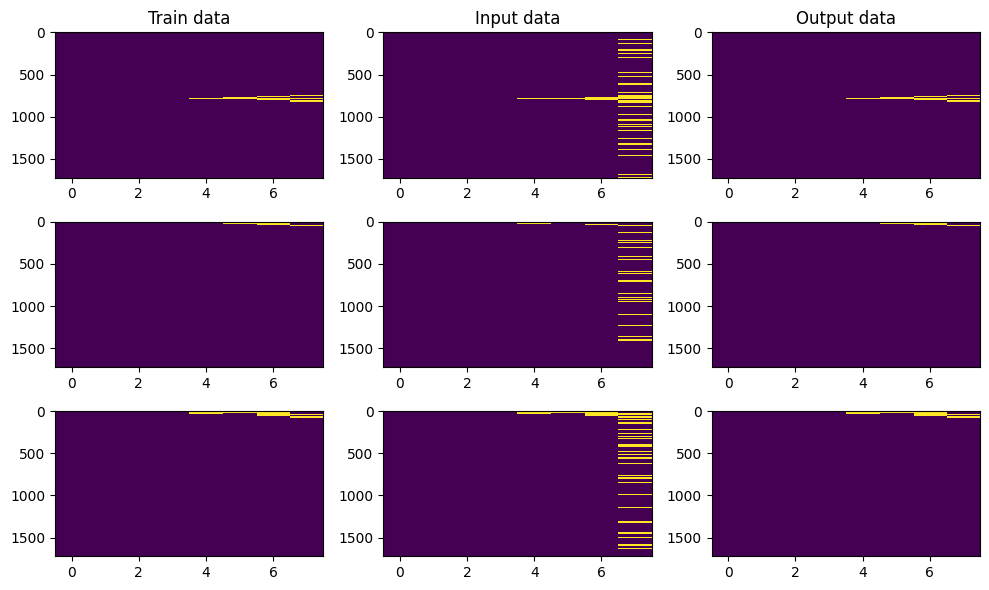

Predicted frequency 1: 9997.706821480408
Predicted frequency 2: 256.0232220609579
Predicted frequency 3: 435.23947750362845


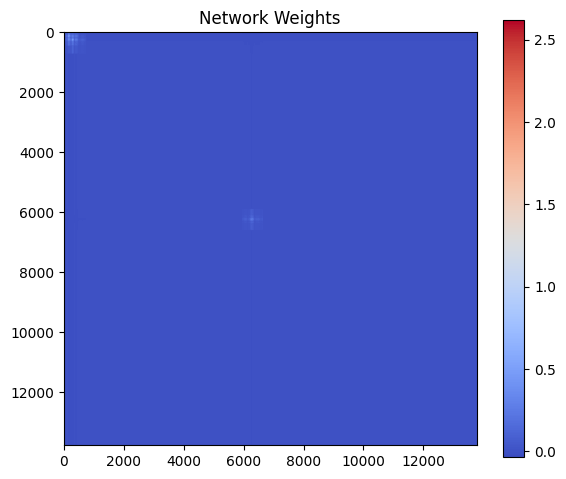

In [14]:
# File names for raw audio
tenk = "./audio/Sine_wave_10k.wav"
two50 = "./audio/Sine_wave_250.wav"
four40 = "./audio/Sine_wave_440.wav"

# Read the wav files
sample_rate, data_10k = wavfile.read(tenk)
_, data_250 = wavfile.read(two50)
_, data_440 = wavfile.read(four40)

# Take the fourier transform of the wav files, reduce the size for memory efficiency TODO: figure out optimal n
fft_result_10k = np.fft.fft(data_10k, len(data_10k)//SCALE_FACTOR)
fft_result_250 = np.fft.fft(data_250, len(data_250)//SCALE_FACTOR)
fft_result_440 = np.fft.fft(data_440, len(data_440)//SCALE_FACTOR)


# Frequencies corresponding to the FFT result
frequencies = np.fft.fftfreq(len(fft_result_10k), 1/sample_rate)

# Binarize and normalize data
norm_bin_data_10k = binarize_audio(normalize(np.abs(fft_result_10k[:len(frequencies)//2]).reshape(-1, 1), axis=0))
norm_bin_data_250 = binarize_audio(normalize(np.abs(fft_result_250[:len(frequencies)//2]).reshape(-1, 1), axis=0))
norm_bin_data_440 = binarize_audio(normalize(np.abs(fft_result_440[:len(frequencies)//2]).reshape(-1, 1), axis=0))

# Initialize the Hopfield network
model = HopfieldNetwork()

# Combine and preprocess training data
raw_data = [norm_bin_data_10k, norm_bin_data_250, norm_bin_data_440]
train_data = np.array([preprocessing(d, w=len(d), h=BIT_PRECISION) for d in raw_data])
print(train_data.shape)

# Train the weights in the network
model.train_weights(train_data)
print("Finished training")

# Corrupt data for testing
print(train_data[0].shape)
corrupted_test_data = [get_corrupted_input(d, corruption_level=2000) for d in [data_10k, data_250, data_440]]
fft_test_data = [np.fft.fft(d, len(d)//SCALE_FACTOR) for d in corrupted_test_data]
mag_test_data = [np.abs(d[:len(d)//2]) for d in fft_test_data]
norm_test_data = [normalize(d.reshape(-1, 1), axis=0) for d in mag_test_data]
bin_test_data = [binarize_audio(d) for d in norm_test_data]
test_data = [preprocessing(d, w=len(d), h=BIT_PRECISION) for d in bin_test_data]

# Make predictions
predicted = model.predict(test_data, num_iter=100, threshold=150, asyn=False)
predicted = np.array(predicted)

# Plot data
print("Show prediction results...")
plot(frequencies[:len(frequencies)//2], train_data, test_data, predicted)

# Get actual frequency predictions
predicted = [d.reshape(d.size // BIT_PRECISION, BIT_PRECISION) for d in predicted]
predicted = [unbinarize_data(d) for d in predicted]

indices = [np.argmax(d) for d in predicted]
#print(indices)

predicted_freqs = [frequencies[i] for i in indices]
#print(predicted_freqs)

for i, f in enumerate(predicted_freqs):
    print(f"Predicted frequency {i + 1}: {f}")

model.plot_weights()

### Getting back the original audio

In [15]:
from audio_processing import mags_to_wav

duration = 3
#num_samples = int(duration * sample_rate)

arr_preds = [d.squeeze() for d in predicted]

for i, mag in enumerate(arr_preds):
    mags_to_wav(f"output_{i}.wav", mag, duration, sample_rate)

'''complex_signals = [d * np.exp(1j * np.random.uniform(0, 2*np.pi, len(d))) for d in arr_preds]

# Step 3: Synthesize Time-domain Signal
time_domain_signals = [np.fft.irfft(sig) for sig in complex_signals]

# Step 4: Normalization
time_domain_signals = [sig / np.max(np.abs(sig)) for sig in time_domain_signals]


# Repeat for desired duration
for i, sig in enumerate(time_domain_signals):
    reps = num_samples // len(sig) + 1
    time_domain_signals[i] = np.tile(sig, reps)[:num_samples]

# Step 5: Convert to WAV
for i, sig in enumerate(time_domain_signals):
    wavfile.write(f'output_{i}.wav', sample_rate, sig.astype(np.float32))'''

"complex_signals = [d * np.exp(1j * np.random.uniform(0, 2*np.pi, len(d))) for d in arr_preds]\n\n# Step 3: Synthesize Time-domain Signal\ntime_domain_signals = [np.fft.irfft(sig) for sig in complex_signals]\n\n# Step 4: Normalization\ntime_domain_signals = [sig / np.max(np.abs(sig)) for sig in time_domain_signals]\n\n\n# Repeat for desired duration\nfor i, sig in enumerate(time_domain_signals):\n    reps = num_samples // len(sig) + 1\n    time_domain_signals[i] = np.tile(sig, reps)[:num_samples]\n\n# Step 5: Convert to WAV\nfor i, sig in enumerate(time_domain_signals):\n    wavfile.write(f'output_{i}.wav', sample_rate, sig.astype(np.float32))"